# **CIFAR-10 Classifier**

The goal of this project is to classify images of smaller version of CIFAR-100 dataset, which is limited to images from 10 different categories.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

Here are the classes in the dataset, as well as 10 random images from each:
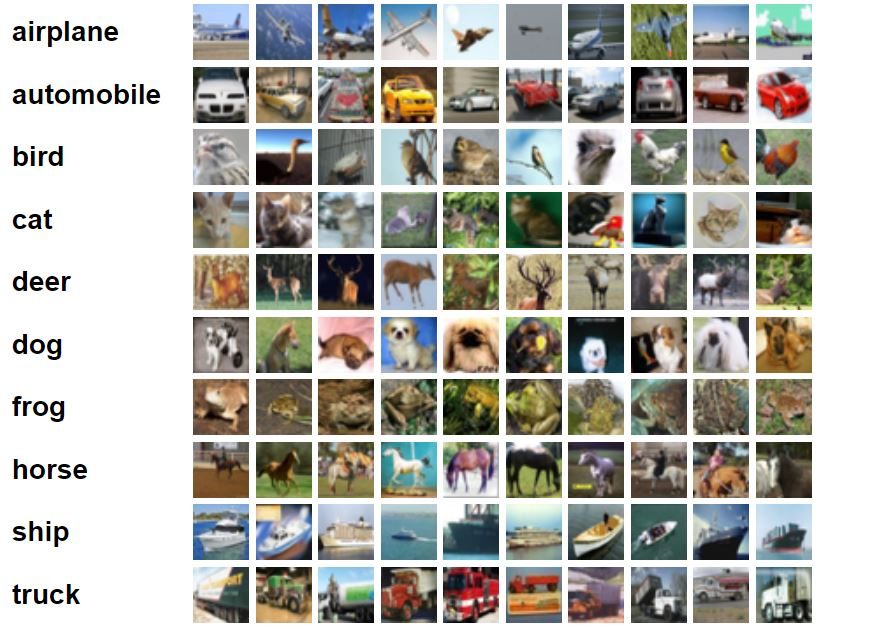

The size of each image in our dataset is 32x32x3. In preprocess section we grayscale all of images, after that the size of each image in dataset will be 32x32, therefore the input layer contains 1024 neurons.





In order to reduce computational complexity we only used only first 4 classes of dataset, so the output layer contains 4 neurons. This neural network has 2 hidden layers and each of them has 16 neurons. 

Here is the architecture of our model:

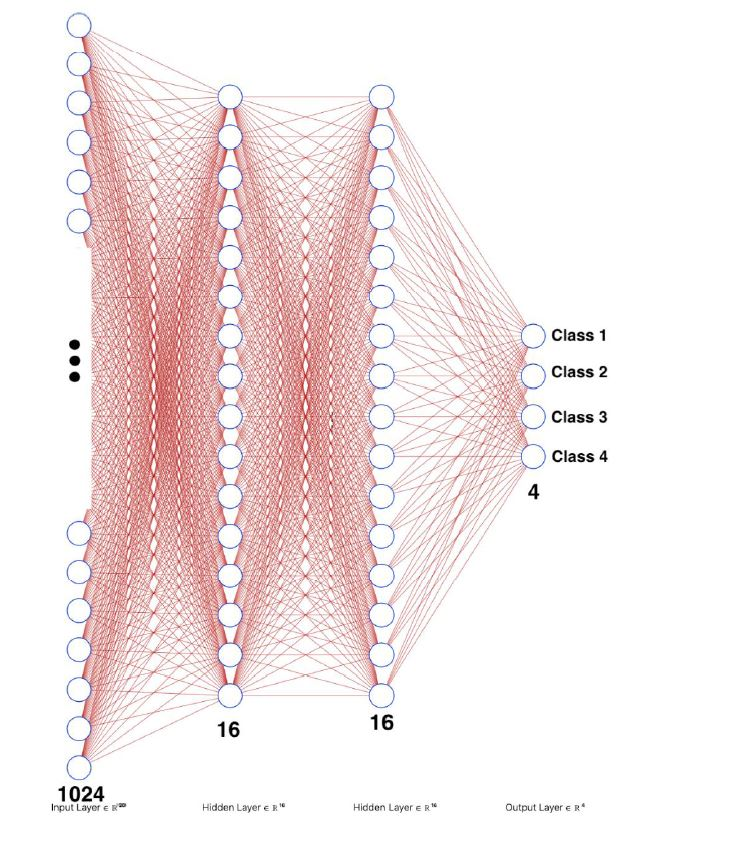

For training the network we used Stochastic Gradient Descent and it has been implemented in two forms of iterative backpropagation and vectorized backpropagation.

First all of the needed libraries should be imported

In [ ]:
# Libraries
from matplotlib import pyplot
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from keras.datasets import cifar10
import os
import numpy as np
from tensorflow.keras.utils import to_categorical
import cv2
import random
import time

# **1. Data Collection, Visualization and Preprocessing**

In [ ]:
# download and extract dataset
!gdown --id 1Y1vgzPvMeVcXSxDfOlCVia7wsU7p8M6g -O CIFAR10.tar.gz
!tar xzf CIFAR10.tar.gz

In this section I loaded the dataset in order to check the size and the some of the images.

Train: X=(50000, 32, 32, 3), y=(50000, 10)
Test: X=(10000, 32, 32, 3), y=(10000, 10)


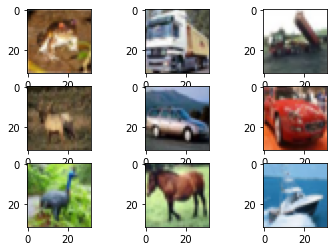

In [ ]:
# load dataset
(trainX, trainY), (testX, testY) = cifar10.load_data()
# one hot encode target values
trainY = to_categorical(trainY)
testY = to_categorical(testY)
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainY.shape))
print('Test: X=%s, y=%s' % (testX.shape, testY.shape))
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	pyplot.imshow(trainX[i])
# show the figure
pyplot.show()

As I mentioned before, in this project only 4 folders of CIFAR-10 dataset has been used. This section has been written to extract the images of first 4 folders and save them into a numpy array using the path of train and test set. 

Train_counter and test_counter are the variables which contains the number of last added image to train_data or test_data, the numpy arrays.

Labels of images are one-hot encoded and saved in another matrix. 

In [ ]:
# find path of train and test folder
train_path = '/content/CIFAR10/train'
test_path = '/content/CIFAR10/test' 
# find number of train and test dataset, first 4 folders
train_num = trainX.shape[0]//10*4 
test_num = testX.shape[0]//10*4
# Matrix (n_samples, width, height, channels)
train_data = np.zeros ((train_num, 32, 32, 3))
test_data = np. zeros ((test_num, 32, 32, 3))
# MAtrix (n_samples, n_classes)
train_labels = np. zeros((train_num, 4))
test_labels = np. zeros ((test_num, 4))
# fill arrays using dataset
train_counter = 0
test_counter = 0
classes_names = os.listdir(train_path)
for i in range(4): 
  # fill train arrays
  for file in os. listdir (os.path.join(train_path, classes_names[i])):
    img = mpimg.imread(os.path.join(train_path, classes_names[i])+'/'+file)
    train_data[train_counter] = img
    # one-hot encoding
    train_labels[train_counter][i] = 1

    train_counter += 1
    
  # fill test arrays
  for file in os.listdir(os.path.join(test_path, classes_names[i])):
    img = mpimg.imread(os.path.join(test_path, classes_names[i])+'/'+file)
    test_data[test_counter] = img
    # one-hot encoding
    test_labels[test_counter][i] = 1

    test_counter += 1


Images have been grayscaled and normalized to reduce complexity.

In [ ]:
# convert RGB data into grayscale in order to reduce complexity 
def rgb2gray(rgb):
  r, g, b = rgb[:, :, :, 0], rgb[:, :, :,1], rgb[:, :, :, 2]
  gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
  return gray

train_data_gray = rgb2gray(train_data)
test_data_gray = rgb2gray(test_data)


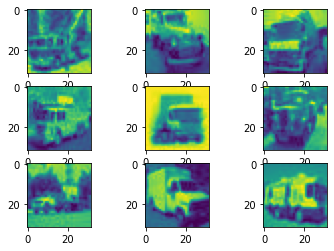

In [ ]:
# check grayscaled images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# plot raw pixel data
	pyplot.imshow(train_data_gray[2*(trainX.shape[0]//10)+i])
# show the figure
pyplot.show()

In [ ]:
# scale pixels to change the range of data between 0 and 1
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

train_norm, test_norm = prep_pixels(train_data_gray, test_data_gray)


Data are flatten since they should be vectorized with the size of 1024.

In [ ]:
# flat data
train_flat = train_norm.reshape(-1, 1024)
test_flat = test_norm.reshape(-1, 1024)

During training and testing the model, data and label of each image must be attached together.

In [ ]:
# make data sets by appending data and labels
train_set = []
test_set = []
for i in range(len(train_flat)):
  train_set.append((train_flat[i].reshape(1024, 1), train_labels[i].reshape(4,1)))

for i in range(len(test_flat)):
  test_set.append((test_flat[i].reshape(1024, 1), test_labels[i].reshape(4,1)))

In [ ]:
# shuffle data matrix
# The result will be in the same order each time
def shuffleFunc():
  return 0.1

random.shuffle(train_set)
random.shuffle(test_set)

# random.shuffle(train_set)
# random.shuffle(test_set)


In [ ]:
# print size to check size
print(len(train_set)) #20000
print(len(test_set)) #4000

20000
4000


# **2. Feedforward**

To calculate the output from the input in neural networks, the following operation is performed in each layer:

  $$ {a^{(L+1)} = {𝜎}(W^{(L+1)}×a^{(L)} + b^{(L+1)})} $$


In this step of project 200 images from train set are seperated, matrix of weights is initialized by random normal numbers and biases are initialized as zero vectors.

The accuracy of model is the number of images which are predicted correctly. Because of random weights and the model, which has not been trained yet, the accuracy is around 25%.






Layers dimensions are defined based on the model architecture and are saved in a list named layers.

In [ ]:
# define layers
layers = [1024, 16, 16, 4]

In [ ]:
# claculate sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [ ]:
# allocate random normal W matrix and zero b vector for each layer.
def initialize_parameters(layers):

    parameters = {}
    center = 0
    margin = 1
    
    for i in range(1, len(layers)):
      # draw random samples from a normal (Gaussian) distribution
      parameters['W'+str(i)] = np.random.normal(center, margin, size = (layers[i], layers[i-1]))
      # zero bias vector
      parameters['b' + str(i)] = np.zeros((layers[i],1))  
    return parameters    

# Initialize parameters
parameters = initialize_parameters(layers)

The result of forwardfeed is saved in a cache, because it will be used during backpropagation.

The activation function of this forward model is sigmoid.

In [ ]:
# return output of the network from forward calculations
def forward_model(new_a, parameters, L):
    caches = []

    # claculate forward process for each layer
    for l in range(1, L):
        prev_a = new_a 
        # extract weight and biase from the list of parameters
        W = parameters['W' + str(l)]
        b = parameters['b' + str(l)]
        # new a is calculated based on the formula, using sigmoid as activation function
        Z = np.dot(W,prev_a) + b
        new_a = sigmoid(Z)
        # cache -> ((a, W, b), z)
        cache = ((prev_a, W, b), Z)

        caches.append(cache)
            
    return new_a, caches

Accuracy is calculated based on correct predictions.

In [ ]:
# calculate accuracy of network's output
def calculate_percentage_of_accuracy(data, parameters):
  correct_perediction = 0
  number_of_data = len(data)
  for i in range(number_of_data):
    # data
    X = data[i][0]
    # label
    Y = np.argmax(data[i][1])
    
    output, caches = forward_model(X, parameters, 4)
    predictedY = np.argmax(output)
    # check if the prediction was correct
    if Y == predictedY:
      correct_perediction += 1

  # calculate acuuracy based on correct predictions
  accuracy = correct_perediction /number_of_data
  
  return accuracy*100


Forward process started using only 200 of train data. 

In [ ]:
# seperate 200 images
train_set_200 = train_set[:200]
test_set_200 = test_set[:200]

# call functions and print accuracy
print("accuracy with random values, before training: " + str(calculate_percentage_of_accuracy(train_set_200, parameters)) + " %")

accuracy with random values, before training: 24.5 %


# **Backpropagation**

During neural network learning process the result of cost function should be minimized.

In this project the cost function is sum of squared errors (SSE)

$$ {Cost =\sum^{n_{L-1}}_{j=0}(a_j^{(L)} - y_j)^2} $$

Gradient Descent is applied to minimize cost function:

$$ {(W, b) = (W, b) - 𝛼∇Cost} $$

Chain rule is applied:

*   Last Layer Derivations:

      - Weight:
$$ {\frac{∂Cost}{∂w_{jk}^{(L)}}=\frac{∂Cost}{∂a_{j}^{(L)}}×\frac{{∂a_{j}^{(L)}}}{∂z_{j}^{(L)}}×\frac{{∂z_{j}^{(L)}}}{w_{jk}^{(L)}} = 2(a_j^{(L)}-y_j)×𝜎^{\prime}(z_j^{(L)})×a_k^{(L-1)}} $$
      - Bias:
$$ {\frac{∂Cost}{∂b_{j}^{(L)}}=\frac{∂Cost}{∂a_{j}^{(L)}}×\frac{{∂a_{j}^{(L)}}}{∂z_{j}^{(L)}}×\frac{{∂z_{j}^{(L)}}}{b_{j}^{(L)}} = 2(a_j^{(L)}-y_j)×𝜎^{\prime}(z_j^{(L)})×1} $$
      - Activation:
$$ {\frac{∂Cost}{∂a_{k}^{(L-1)}}=\sum^{n_{L-1}}_{j=0}(\frac{∂Cost}{∂a_{j}^{(L)}}×\frac{{∂a_{j}^{(L)}}}{∂z_{j}^{(L)}}×\frac{{∂z_{j}^{(L)}}}{a_{k}^{(L-1)}})} $$

*   Other Layers Derivations:

      - Weight:
$$ {\frac{∂Cost}{∂w_{km}^{(L-1)}}=\frac{∂Cost}{∂a_{k}^{(L-1)}}×𝜎^{\prime}(z_k^{(L-1)})×a_m^{(L-2)}} $$
      - Bias:
$$ {\frac{∂Cost}{∂b_{k}^{(L-1)}}=\frac{∂Cost}{∂a_{k}^{(L-1)}}×𝜎^{\prime}(z_k^{(L-1)})×1} $$
      - Activation:
$$ {\frac{∂Cost}{∂a_{m}^{(L-2)}}=\sum^{n_{L-2}}_{k=0}(\frac{∂Cost}{∂a_{k}^{(L-1)}}×𝜎^{\prime}(z_k^{(L-1)}×w_{km}^{(L-1)})} $$


So the rest of implementation is based on these computations.



In [ ]:
# calculate SSE cost 
def compute_cost(output, Y):
    cost = ((output - Y)**2).sum()
    return cost

In [ ]:
# calculate derivation of sigmoid
def sigmoid_deriv(z):
    a = sigmoid(z)
    return a * (1 - a)

# 3. with "for loops"

The size of each gradient calculated based on the reached formulas.

In [ ]:
# create np zeros for all needed gradients based on size of layers
def create_gradients_zeros(layers):
    grad_a2 = np.zeros((layers[2], 1))
    grad_a1 = np.zeros((layers[1], 1))
    grad_W3 = np.zeros((layers[3], layers[2]))
    grad_W2 = np.zeros((layers[2], layers[1]))
    grad_W1 = np.zeros((layers[1], layers[0]))
    grad_b3 = np.zeros((layers[3], 1))
    grad_b2 = np.zeros((layers[2], 1))         
    grad_b1 = np.zeros((layers[1], 1))
    
    return grad_a2, grad_a1, grad_W3, grad_W2, grad_W1, grad_b3, grad_b2, grad_b1

In [ ]:
# extract parameters which has been saved during forwardfeeding from the cache
def extract_parameters(caches):
    # cache -> ((a, W, b), z)
    a2 = caches[2][0][0]
    a1 = caches[1][0][0]
    a0 = caches[0][0][0]

    W3 = caches[2][0][1]
    W2 = caches[1][0][1]
    W1 = caches[0][0][1]
    
    z3 = caches[2][1]
    z2 = caches[1][1]
    z1 = caches[0][1]
    
    return a2, a1, a0, W3, W2, W1, z3, z2, z1

In this section the graiedients are calculated based on the formulas. Here used method is "for Loop" and that is the reason of low speed.

The saved data in cache is used here.

In [ ]:
# calculate gradients of wights and biases
def backpropagation_for_loop(caches, output, y, layers):
  
    a3 = output

    a2, a1, a0, W3, W2, W1, z3, z2, z1 = extract_parameters(caches)

    grad_a2, grad_a1, grad_W3, grad_W2, grad_W1, grad_b2, grad_b1, grad_b0 = create_gradients_zeros(layers)

    # calculat gradients of out put of layer(a)
    for k in range(layers[2]):
        for j in range(layers[3]):
            grad_a2[k, 0] += W3[j, k] * sigmoid_deriv(z3[j, 0]) * (2 * a3[j,0]- 2 * y[j,0])

    for m in range(layers[1]):
        for k in range(layers[2]):
            grad_a1[m, 0] += W2[k, m] * sigmoid_deriv(z2[k, 0]) * grad_a2[k, 0]
    
    # calculate gradients of weights
    for j in range(layers[3]):
        for k in range(layers[2]):
            grad_W3[j, k] += a2[k, 0] * sigmoid_deriv(z3[j, 0]) * (2 * a3[j,0]- 2 * y[j,0]) 

    for k in range(layers[2]):
        for m in range(layers[1]):
            grad_W2[k, m] += a1[m, 0] * sigmoid_deriv(z2[k, 0]) * grad_a2[k, 0]
    
    for m in range(layers[1]):
        for v in range(layers[0]):
            grad_W1[m, v] += a0[v, 0] * sigmoid_deriv(z1[m, 0]) * grad_a1[m, 0]

    # calculate gradients of biases
    for j in range(layers[3]):
        grad_b2[j ,0] += 1 * sigmoid_deriv(z3[j, 0]) * (2 * a3[j,0]- 2 * y[j,0]) 
           
    for k in range(layers[2]):
        grad_b1[k ,0] += 1 * sigmoid_deriv(z2[k, 0]) * grad_a2[k, 0]
               
    for m in range(layers[1]):
        grad_b0[m ,0] += 1 * sigmoid_deriv(z1[m, 0]) * grad_a1[m, 0]
        
    # define a dictionare
    # keys -> label of gradients
    # values -> gradients
    gradients = {}
    gradients["db1"] = grad_b0
    gradients["db2"] = grad_b1
    gradients["db3"] = grad_b2
    gradients["dW1"] = grad_W1
    gradients["dW2"] = grad_W2
    gradients["dW3"] = grad_W3
    
    return gradients


# 4. Vectorization

Instead of for loop matrix operations are applied, this reduces execution time.

In [ ]:
# calculate gradients of wights and biases
def backpropagation_vectorized(caches, output, y, layers):

    a3 = output
    a2, a1, a0, W3, W2, W1, z3, z2, z1 = extract_parameters(caches)

    grad_a2, grad_a1, grad_W3, grad_W2, grad_W1, grad_b2, grad_b1, grad_b0 = create_gradients_zeros(layers)
    
    # calculat gradients of out put of layer(a)
    grad_a2 += np.transpose(W3) @ (2 * sigmoid_deriv(z3) * (a3 - y))
    grad_a1 += np.transpose(W2) @ ( sigmoid_deriv(z2) * grad_a2)


    # calculate gradients of weights
    grad_W3 += (2 * sigmoid_deriv(z3) * (a3 - y)) @ (np.transpose(a2))
    grad_W2 += (sigmoid_deriv(z2) * grad_a2) @ (np.transpose(a1))
    grad_W1 += (2 * sigmoid_deriv(z1) * grad_a1) @ (np.transpose(a0))

    # calculate gradients of biases
    grad_b2 += (2 * sigmoid_deriv(z3) * (a3 - y))
    grad_b1 += (sigmoid_deriv(z2) * grad_a2)
    grad_b0 += (sigmoid_deriv(z1) * grad_a1)

    # define a dictionare
    # keys -> label of gradients
    # values -> gradients 
    gradients = {}
    gradients["db1"] = grad_b0
    gradients["db2"] = grad_b1
    gradients["db3"] = grad_b2
    gradients["dW1"] = grad_W1
    gradients["dW2"] = grad_W2
    gradients["dW3"] = grad_W3
    
    return gradients

During train operation parameters inculded weights and biases should be updated, also cost should be computed based on gradients

In [ ]:
# apply stochastic gradient descent on input train_set and update weights
def train(train_set, learning_rate, epochs, batch_size, layers, vectorized):
    # save start time to caculate training time
    start_time = time.time()

    # initialize W and b
    parameters = initialize_parameters(layers)
    
    total_costs = []
    layers_len = len(layers)
    for i in range(epochs):
        if i%10==0:
          print("EPOCH ", i)

        # data must be shuffled each epoch time
        random.shuffle(train_set)
        cost = 0
        train_set_size = len(train_set)
        batch_num = train_set_size//batch_size

        for n in range(batch_num):
            # make zero arrays for gradients
            grad_a2, grad_a1, grad_W3, grad_W2, grad_W1, grad_b3, grad_b2, grad_b1 = create_gradients_zeros(layers)
            
            # which batch of train set is using to train
            first_train_data = n * batch_size
            last_train_data = (n+1) * batch_size
            batch = train_set[first_train_data: last_train_data]
            
            for b in batch:

                batch_data = b[0]
                batch_label = b[1]
                output, caches = forward_model(batch_data, parameters, layers_len)

                # if vectorized is false backpropagation_for_loop should be called, 
                # which is slower, because of using for loop.
                if not vectorized:
                  gradients = backpropagation_for_loop(caches, output, batch_label, layers)
                
                # if vectorized was true backpropagation_vectorized should be called, 
                # which is faster, because of using matrix operations.
                else:
                  gradients = backpropagation_vectorized(caches, output, batch_label, layers)

                # extract gradients and add them
                grad_b3 += gradients["db3"]
                grad_b2 += gradients["db2"]
                grad_b1 += gradients["db1"]
                grad_W3 += gradients["dW3"]
                grad_W2 += gradients["dW2"]
                grad_W1 += gradients["dW1"]

                # cost of this item in batch added to total cost oc this batch
                cost += compute_cost(output, batch_label)
            
            # update parameters, weights and biases
            for l in range(layers_len-1):
                parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * (gradients["dW" + str(l+1)]/ batch_size)
                parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * (gradients["db" + str(l+1)]/ batch_size)
        
        total_costs.append(cost/train_set_size)
        # save end time to caculate training time
        end_time = time.time()
                
    return parameters, total_costs, start_time, end_time        

# Plotting Functions

In [ ]:
#plot epoch cost
def plot_cost_epoch(epochs_costs):
  plt.plot(epochs_costs)
  total_costs_size = len(epochs_costs)
  plt.xticks(np.arange(total_costs_size), np.arange(1, total_costs_size+1))
  plt.xlabel("Epoch")
  plt.ylabel("Cost")
  plt.show()

In [ ]:
# plot accuracy in 10 runs
def plot_10_results(train_accs, test_accs):
    test_size = len(test_accs)
    # plt.title("Train and test accuracy per trial")
    plt.plot(train_accs, label='train acc')
    plt.plot(test_accs, label='test acc')
    plt.xticks(np.arange(test_size), np.arange(1, test_size+1))
    plt.legend()
    plt.xlabel("Train number")
    plt.ylabel("Accuracy")
    
    total_mean_acc = sum(test_accs)/test_size
    txt = f"Mean test accuracy for 10 train is {total_mean_acc}"
    plt.figtext(0.5, -0.05, txt, wrap=True, horizontalalignment='center', fontsize=11)
    plt.show

In [ ]:
# plot costs in 10 runs
def plot_10_costs(costs):
    # number of rows
    r = len(costs)//5
    fig, axs = plt.subplots(r, 5, sharex=True, sharey=True, figsize=(15,5))
    
    fig.suptitle('Costs per epoch for each Train')
    for i in range(r):
        for j in range(5):
            axs[i, j].plot(costs[i*5+j])
            axs[i, j].set_title(f'Tain #{i*5+j+1}')
            axs[i, j].set(xlabel='Epoch', ylabel='Cost')
            axs[i, j].label_outer()
            axs[i, j].set_xticks(np.arange(0, len(costs[i*5+j]), 4))
            axs[i, j].set_xticklabels(np.arange(1, len(costs[i*5+j])+1, 4))
    fig.tight_layout()

# Train Neural Network on 200 Train Data Using for Loop

In [ ]:
# Set hyperparameters
batch_size = 16
learning_rate = 0.3
number_of_epochs = 10

trained_params_for_loop, total_costs_for_loop, start_time, end_time = train(train_set_200, learning_rate, number_of_epochs, batch_size, layers, False)

print(f"Training lasted {end_time - start_time} seconds")

EPOCH  0
Training lasted 300.6626121997833 seconds


Plot Training Result

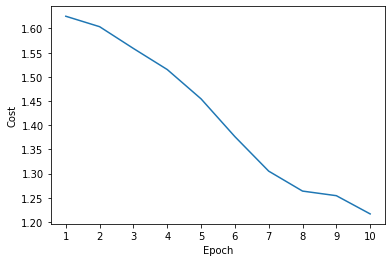

In [ ]:
plot_cost_epoch(total_costs_for_loop)

Calculate Accuracy

In [ ]:
print("Accuracy after training process:")
print("on train data: " + str(calculate_percentage_of_accuracy(train_set_200, trained_params_for_loop)) + " %")
print("on test data: " + str(calculate_percentage_of_accuracy(test_set_200, trained_params_for_loop)) + " %")

Accuracy after training process:
on train data: 24.0 %
on test data: 20.5 %


# Train Neural Network on 200 Train Data Using Vectorization

In [ ]:
# Set hyperparameters
batch_size = 16
learning_rate = 0.3
number_of_epochs = 20

trained_params_vectorized, total_costs_vectorized, start_time, end_time = train(train_set_200, learning_rate, number_of_epochs, batch_size, layers, True)

print(f"Training lasted {end_time - start_time} seconds")

EPOCH  0
EPOCH  10
Training lasted 1.8144116401672363 seconds


Plot Training Result

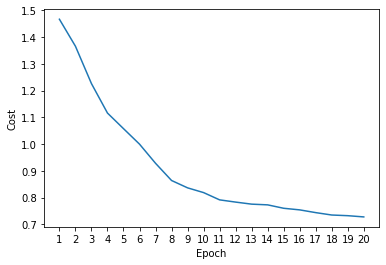

In [ ]:
plot_cost_epoch(total_costs_vectorized)

Calculate Accuracy

In [ ]:
print("Accuracy after training process:")
print("on train data: " + str(calculate_percentage_of_accuracy(train_set_200, trained_params_vectorized)) + " %")
print("on test data: " + str(calculate_percentage_of_accuracy(test_set_200, trained_params_vectorized)) + " %")

Accuracy after training process:
on train data: 32.5 %
on test data: 31.0 %


# Train the Model and Run the Vectorized Backpropagation 10 Times

Because of vectorization training is faster, so we trained our model 10 time and showed the total mean. 

In [ ]:
# train network 10 times and return the results such as train, test accuracy and costs
def run_10_times(train_set, test_set, learning_rate, number_of_epochs, batch_size, layers, vectorized):
    # lists to save the result of trainings
    costs = []
    train_accuracy = []
    test_accuracy = []
    # train 10 times and cost and acc of each train and test will be added to their list
    for i in range(10):
        trained_params_10, epochs_costs_10, start_time, end_time = train(train_set, learning_rate, number_of_epochs, batch_size, layers, True)
        train_acc = calculate_percentage_of_accuracy(train_set, trained_params_10)
        test_acc = calculate_percentage_of_accuracy(test_set, trained_params_10)
        train_accuracy.append(train_acc)
        test_accuracy.append(test_acc)
        costs.append(epochs_costs_10)
    
    return train_accuracy, test_accuracy, costs

In [ ]:
# # Set hyperparameters
learning_rate = 0.3
number_of_epochs = 20
batch_size = 16

train_accs, test_accs, costs = run_10_times(train_set_200, test_set_200, learning_rate, number_of_epochs, batch_size, layers, True)

EPOCH  0
EPOCH  10
EPOCH  0
EPOCH  10
EPOCH  0
EPOCH  10
EPOCH  0
EPOCH  10
EPOCH  0
EPOCH  10
EPOCH  0
EPOCH  10
EPOCH  0
EPOCH  10
EPOCH  0
EPOCH  10
EPOCH  0
EPOCH  10
EPOCH  0
EPOCH  10


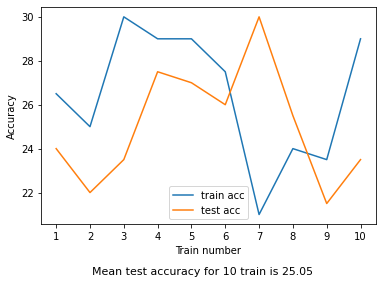

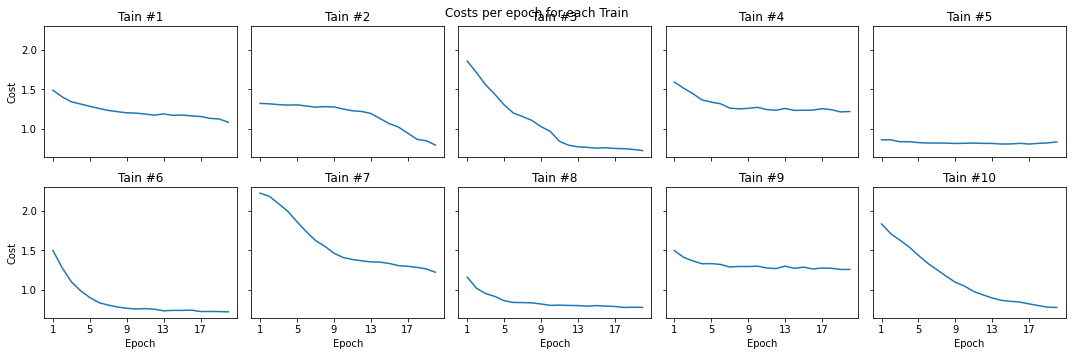

In [ ]:
plot_10_results(train_accs, test_accs)
plot_10_costs(costs)

# **5. Test Model**

Because the model has been optimal, we increased the number of data and epochs.

In [ ]:
# seperate 8000 images randomly
random.shuffle(train_set)
random.shuffle(test_set)

train_set_8000 = train_set[:8000]
test_set_8000 = test_set[:8000]

In [ ]:
learning_rate = 0.3
number_of_epochs = 40
batch_size = 16

trained_params, epochs_costs, start_time, end_time = train(train_set_8000, learning_rate, number_of_epochs, batch_size, layers, True)
print(f"Training lasted {end_time - start_time} seconds")

EPOCH  0
EPOCH  10
EPOCH  20
EPOCH  30
Training lasted 145.80491161346436 seconds


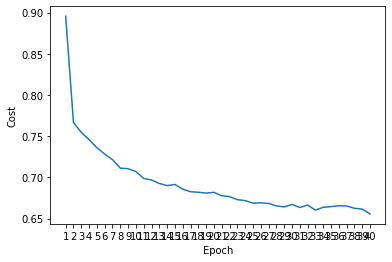

In [ ]:
plot_cost_epoch(epochs_costs)

In [ ]:
print("Accuracy after training process:")
print("on train data: " + str(calculate_percentage_of_accuracy(train_set_8000, trained_params)) + " %")
print("on test data: " + str(calculate_percentage_of_accuracy(test_set_8000, trained_params)) + " %")

Accuracy after training process:
on train data: 45.074999999999996 %
on test data: 42.3 %


In [ ]:
# average accuracy for 10 runs:
train_accsuracy, test_accsuracy, costs = run_10_times(train_set_8000, test_set_8000, learning_rate, number_of_epochs, batch_size, layers, True)
total_mean_acc = sum(test_accsuracy)/len(test_accsuracy)
print(f"Mean test accuracy for 10 time training is {total_mean_acc}")

EPOCH  0
EPOCH  10
EPOCH  20
EPOCH  30
EPOCH  0
EPOCH  10
EPOCH  20
EPOCH  30
EPOCH  0
EPOCH  10
EPOCH  20
EPOCH  30
EPOCH  0
EPOCH  10
EPOCH  20
EPOCH  30
EPOCH  0
EPOCH  10
EPOCH  20
EPOCH  30
EPOCH  0
EPOCH  10
EPOCH  20
EPOCH  30
EPOCH  0
EPOCH  10
EPOCH  20
EPOCH  30
EPOCH  0
EPOCH  10
EPOCH  20
EPOCH  30
EPOCH  0
EPOCH  10
EPOCH  20
EPOCH  30
EPOCH  0
EPOCH  10
EPOCH  20
EPOCH  30
Mean test accuracy for 10 trial is 41.7925


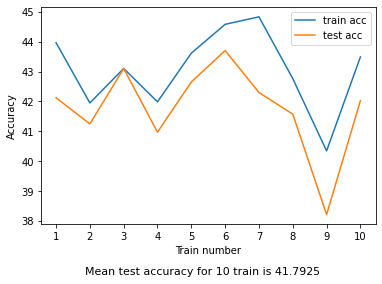

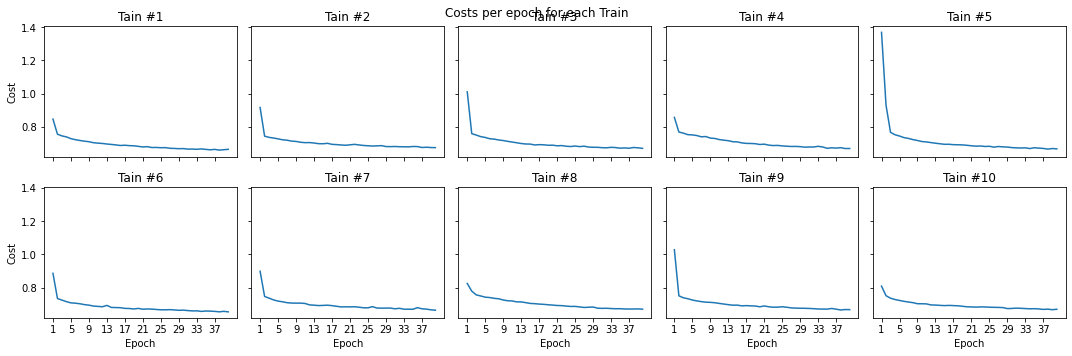

In [ ]:
plot_10_results(train_accs, test_accs)
plot_10_costs(costs)